<a href="https://colab.research.google.com/github/chandini2595/Neural_Network_Implementation_Types/blob/main/Colab/Using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import tensorflow.keras.backend as K

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

def generate_data(n_samples=1000):
    X1 = np.random.uniform(-5, 5, n_samples)
    X2 = np.random.uniform(-5, 5, n_samples)
    X3 = np.random.uniform(-5, 5, n_samples)

    # Non-linear function
    y = (2 * np.sin(X1) + 0.5 * X2**2 + 0.3 * X3**3 +
         np.cos(X1 * X2) + np.random.normal(0, 0.2, n_samples))

    X = np.column_stack((X1, X2, X3))
    return X.astype(np.float32), y.astype(np.float32)

# Generate data
X_train, y_train = generate_data(1000)
X_val, y_val = generate_data(200)
X_test, y_test = generate_data(200)

In [2]:
class LowLevelTF:
    def __init__(self, learning_rate=0.001):
        # Initialize weights and biases
        self.W1 = tf.Variable(tf.random.normal([3, 64]) * tf.sqrt(2.0/3))
        self.b1 = tf.Variable(tf.zeros([64]))

        self.W2 = tf.Variable(tf.random.normal([64, 32]) * tf.sqrt(2.0/64))
        self.b2 = tf.Variable(tf.zeros([32]))

        self.W3 = tf.Variable(tf.random.normal([32, 16]) * tf.sqrt(2.0/32))
        self.b3 = tf.Variable(tf.zeros([16]))

        self.W4 = tf.Variable(tf.random.normal([16, 1]) * tf.sqrt(2.0/16))
        self.b4 = tf.Variable(tf.zeros([1]))

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    def forward(self, x):
        # First layer
        z1 = tf.matmul(x, self.W1) + self.b1
        a1 = tf.nn.relu(z1)
        a1 = tf.nn.dropout(a1, 0.2)

        # Second layer
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = tf.nn.relu(z2)
        a2 = tf.nn.dropout(a2, 0.2)

        # Third layer
        z3 = tf.matmul(a2, self.W3) + self.b3
        a3 = tf.nn.relu(z3)
        a3 = tf.nn.dropout(a3, 0.2)

        # Output layer
        return tf.matmul(a3, self.W4) + self.b4

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self.forward(x)
            loss = tf.reduce_mean(tf.square(predictions - y))

        gradients = tape.gradient(loss, [self.W1, self.b1, self.W2, self.b2,
                                       self.W3, self.b3, self.W4, self.b4])
        self.optimizer.apply_gradients(zip(gradients, [self.W1, self.b1, self.W2, self.b2,
                                                     self.W3, self.b3, self.W4, self.b4]))
        return loss

In [3]:
def create_sequential_model():
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(3,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                 loss='mse',
                 metrics=['mae'])
    return model

In [4]:
def create_functional_model():
    inputs = layers.Input(shape=(3,))

    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                 loss='mse',
                 metrics=['mae'])
    return model

In [5]:
class SubclassModel(tf.keras.Model):
    def __init__(self):
        super(SubclassModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.2)

        self.dense2 = layers.Dense(32, activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.2)

        self.dense3 = layers.Dense(16, activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.2)

        self.output_layer = layers.Dense(1)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)

        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.dropout2(x, training=training)

        x = self.dense3(x)
        x = self.bn3(x, training=training)
        x = self.dropout3(x, training=training)

        return self.output_layer(x)

In [8]:
def train_and_evaluate(model_type='sequential'):
    if model_type == 'low_level':
        model = LowLevelTF()
        # Training loop for low-level implementation
        losses = []
        for epoch in range(100):
            loss = model.train_step(X_train, y_train)
            if epoch % 10 == 0:
                val_pred = model.forward(X_val)
                val_loss = tf.reduce_mean(tf.square(val_pred - y_val))
                print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
            losses.append(loss)
    else:
        if model_type == 'sequential':
            model = create_sequential_model()
        elif model_type == 'functional':
            model = create_functional_model()
        elif model_type == 'subclass':
            model = SubclassModel()
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Train model
        history = model.fit(X_train, y_train,
                          epochs=100,
                          batch_size=32,
                          validation_data=(X_val, y_val),
                          verbose=1)
        losses = history.history['loss']

    return model, losses

def plot_results(model, losses, model_type):
    plt.figure(figsize=(20, 5))

    # Plot training loss
    plt.subplot(131)
    plt.plot(losses)
    plt.title(f'{model_type} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Make predictions
    if model_type == 'low_level':
        y_pred = model.forward(X_test)
    else:
        y_pred = model.predict(X_test)

    # Convert to numpy and flatten
    y_pred_np = y_pred.numpy() if isinstance(y_pred, tf.Tensor) else y_pred

    # Plot 4D scatter
    ax = plt.subplot(132, projection='3d')
    scatter = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                        c=y_pred_np.ravel(),  # Using ravel() instead of flatten()
                        cmap='viridis')
    plt.colorbar(scatter)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    plt.title('4D Scatter Plot')

    # Plot actual vs predicted
    plt.subplot(133)
    plt.scatter(y_test, y_pred_np)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    plt.tight_layout()
    plt.show()


Training low_level model...
Epoch 0, Loss: 239.2339, Val Loss: 260.8392
Epoch 10, Loss: 233.1728, Val Loss: 256.5887
Epoch 20, Loss: 231.7195, Val Loss: 256.4308
Epoch 30, Loss: 230.6951, Val Loss: 254.2507
Epoch 40, Loss: 230.4770, Val Loss: 255.0766
Epoch 50, Loss: 229.7415, Val Loss: 253.8044
Epoch 60, Loss: 229.2977, Val Loss: 254.0019
Epoch 70, Loss: 229.3692, Val Loss: 253.8521
Epoch 80, Loss: 229.1179, Val Loss: 253.8878
Epoch 90, Loss: 228.8520, Val Loss: 253.1416


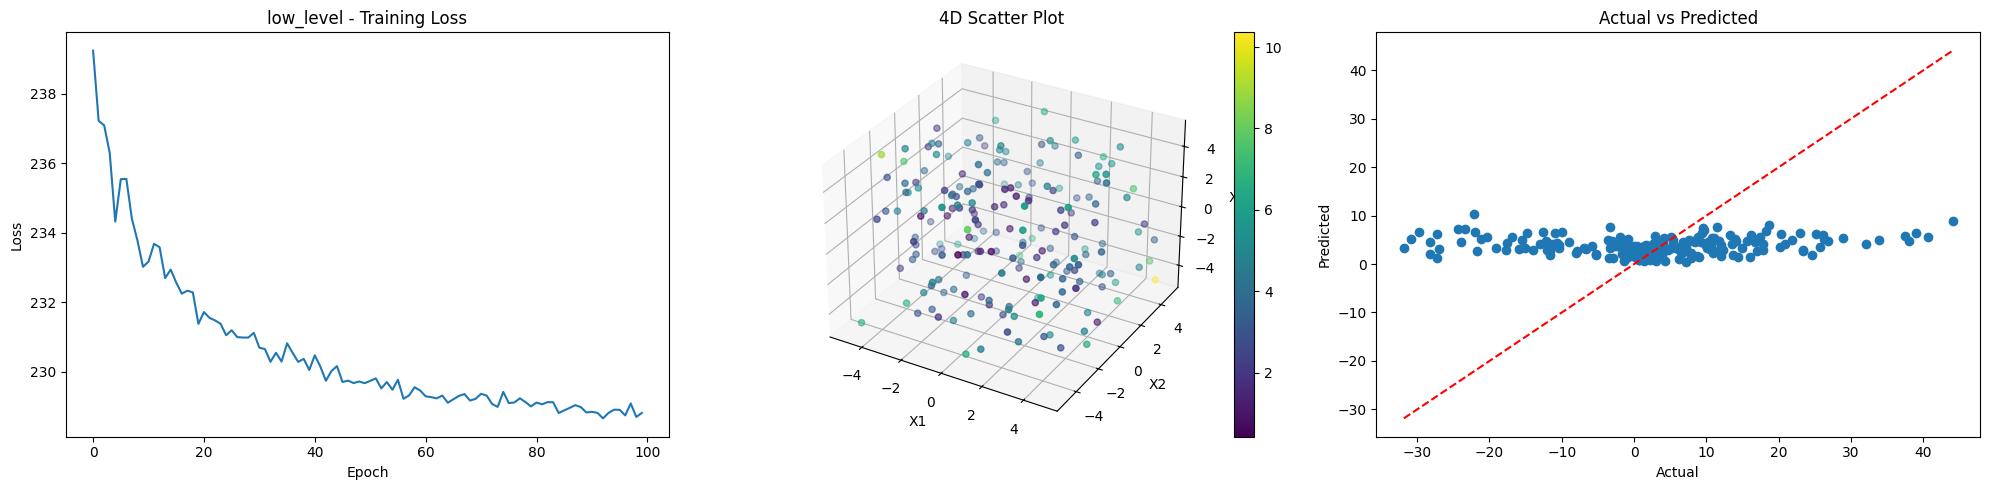


low_level Model Test Predictions:
Input: (-4, -4, -4)
Prediction: 7.578
Actual: -10.644
Difference: 18.222

Input: (-2, -2, -2)
Prediction: 3.639
Actual: -2.872
Difference: 6.512

Input: ( 0,  0,  0)
Prediction: 0.344
Actual: 1.000
Difference: 0.656

Input: ( 2,  2,  2)
Prediction: 2.847
Actual: 5.565
Difference: 2.718

Input: ( 4,  4,  4)
Prediction: 5.389
Actual: 24.729
Difference: 19.340


Training sequential model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 246.8226 - mae: 11.8614 - val_loss: 228.8292 - val_mae: 10.9261
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 195.4375 - mae: 10.4791 - val_loss: 195.4967 - val_mae: 10.0624
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 168.1650 - mae: 9.6851 - val_loss: 163.3472 - val_mae: 9.1993
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 146.6783 - mae: 9.1224 - val_loss: 135.6485 - val_mae: 8.3949
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 133.4840 - mae: 8.6386 - val_loss: 114.0140 - val_mae: 7.6704
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 116.3618 - mae: 8.0688 - val_loss: 95.2559 - val_mae: 6.9500
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 104.1869 - mae: 7.6212 - val_loss: 81.5522 - val_mae: 6.3830
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 91.5503 - mae: 6.9867 - val_loss: 69.1592 - val_mae: 5.8447
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6

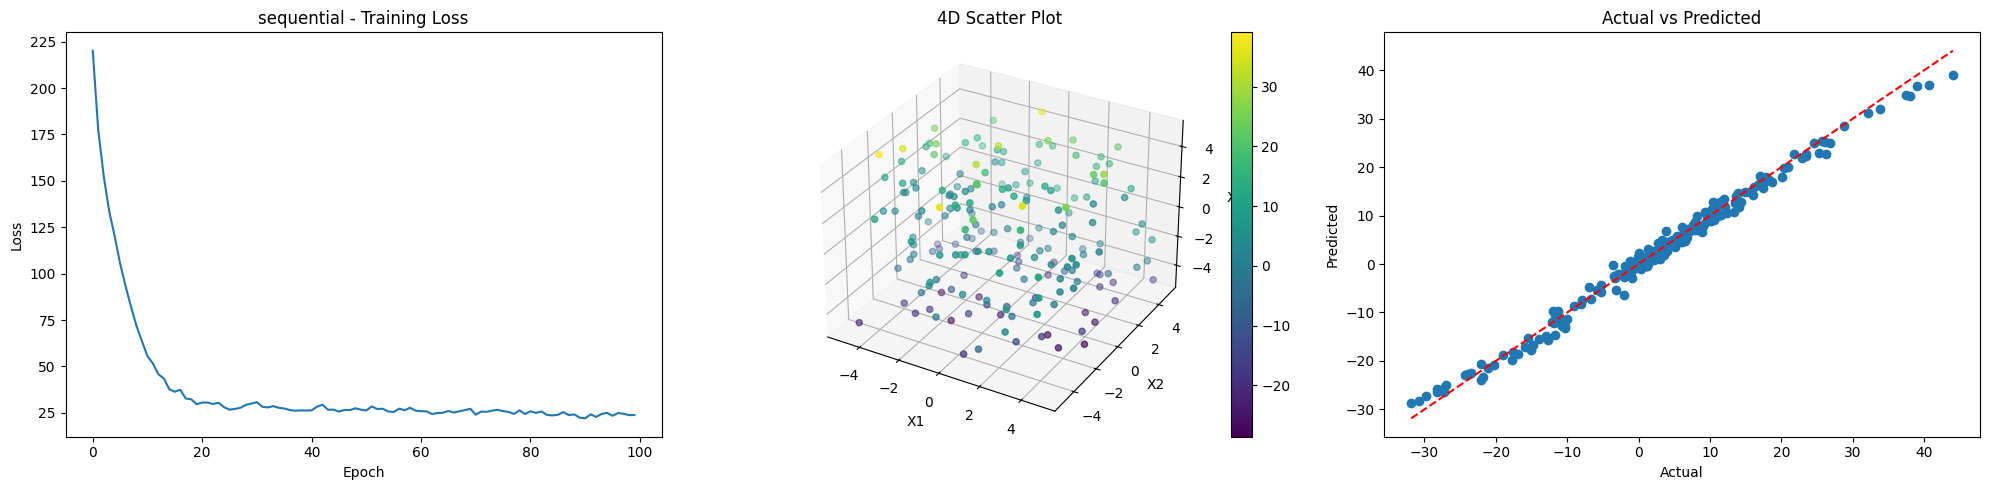


sequential Model Test Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Input: (-4, -4, -4)
Prediction: -14.535
Actual: -10.644
Difference: 3.891

Input: (-2, -2, -2)
Prediction: -2.251
Actual: -2.872
Difference: 0.621

Input: ( 0,  0,  0)
Prediction: 0.787
Actual: 1.000
Difference: 0.213

Input: ( 2,  2,  2)
Prediction: 5.658
Actual: 5.565
Difference: 0.093

Input: ( 4,  4,  4)
Prediction: 22.702
Actual: 24.729
Difference: 2.027


Training functional model...
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 244.8479 - mae: 11.7407 - val_loss: 238.1555 - val_mae: 11.2435
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 207.4523 - mae: 10.8573 - val_loss: 211.8827 - val_mae: 10.6398
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 183.3457 - mae: 10.3220 - val_loss: 184.2001 - val_mae: 9.9751
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 161.0216 - mae: 9.6374 - val_loss: 154.0835 - val_mae: 9.1437
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
def main():
    # Train and evaluate all model variants
    model_types = ['low_level', 'sequential', 'functional', 'subclass']

    for model_type in model_types:
        print(f"\nTraining {model_type} model...")
        model, losses = train_and_evaluate(model_type)
        plot_results(model, losses, model_type)

        # Test predictions
        test_points = np.array([
            [-4, -4, -4],
            [-2, -2, -2],
            [0, 0, 0],
            [2, 2, 2],
            [4, 4, 4]
        ], dtype=np.float32)

        print(f"\n{model_type} Model Test Predictions:")
        if model_type == 'low_level':
            predictions = model.forward(test_points).numpy()  # Convert to numpy
        else:
            predictions = model.predict(test_points)

        for i, (x1, x2, x3) in enumerate(test_points):
            actual = 2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + np.cos(x1 * x2)
            pred = predictions[i][0]
            print(f"Input: ({x1:2.0f}, {x2:2.0f}, {x3:2.0f})")
            print(f"Prediction: {pred:.3f}")
            print(f"Actual: {actual:.3f}")
            print(f"Difference: {abs(pred - actual):.3f}\n")

if __name__ == "__main__":
    main()